# Snakemake on AWS ParallelCluster 

## Introduction

### AWS ParallelCluster 
AWS ParallelCluster is a fully managed tool that simplifies the creation, management, and deployment of High-Performance Computing (HPC) clusters on the AWS cloud. It automates the setup and running of HPC clusters. Users can define their cluster configurations, including instance types, storage options, install scripts, and advanced networking settings like VPC, subnets, and security groups.

AWS ParallelCluster integrates with  HPC schedulers like Slurm, offering robust job scheduling and resource management. 

### Snakemake and the `pcluster-slurm` plugin

Snakemake is a workflow manager that simplifies the process of creating and executing complex data analysis pipelines. It uses a Python-based language to define workflows and automate the execution of tasks. 

Snakemake workflows can be deployed seamlessly on AWS ParallelCluster using the `pcluster-slurm` plugin. This plugin enables the use of Slurm via AWS ParallelCluster as an executor for Snakemake workflows. 

## Setup 

### Dependencies 

* AWS ParallelCluster UI 

Please follow the installation instructions for the ParallelCluster UI provided here: [here](https://github.com/STRIDES/NIHCloudLabAWS/blob/main/docs/Install_AWSParallelCluster.md). These instructions will guide you through the necessary steps to create a CloudFormation Stack through which you can access the AWS ParallelCluster UI. 

Additionally, we urge you to check out the documents within the `docs/` folder of the repository for more bioinformatics and Gen AI tutorials.

Once you have created the Cloud Formation Stack for the PCUI, navigate to the user interface URL. It will look like this:

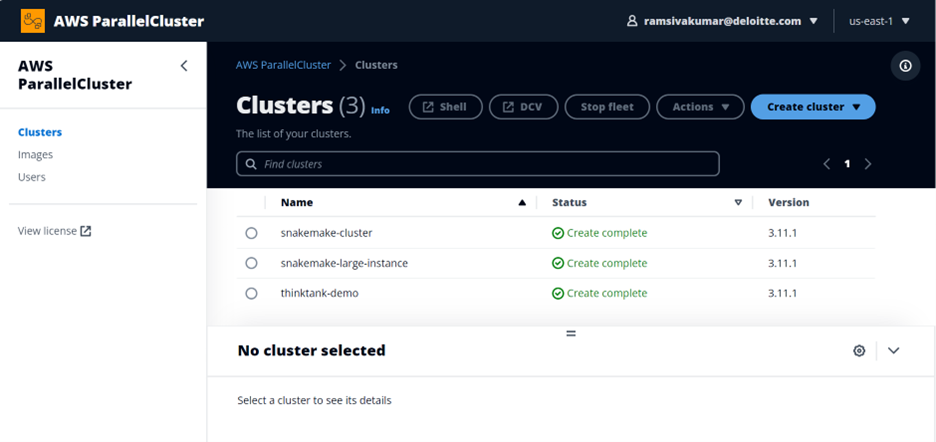

### Create a Cluster 
Let's create a cluster within the ParallelCluster environment.

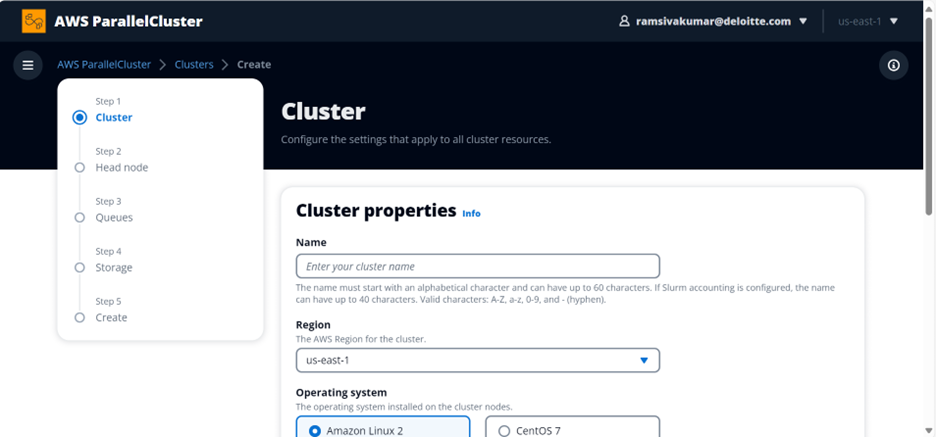

1. In the PCUI Clusters view, choose **Create cluster** > **Step by step**.
2. In Cluster, **Name**, enter a name for your cluster.
3. Choose a **VPC** from the available options and choose Next. CloudLab users will have access to pre-configured VPC networks.
4. In **Head node**, choose Add **SSM session**. This will allow you to access the head node through the **`Shell`** button. Change the instance type of your head node to **t2.xlarge**. 
5. In **Queues**, provide a name and subnet for your queue.
6. In **Compute resources**, choose 1 for **Static nodes** and select **c5n.large** as the instance type for your compute resources. 
7. In Storage, choose Next.
8. In Cluster configuration, review the cluster configuration YAML and choose **Dry run** to 
validate it.
1. Choose **Create** to create your cluster, based on the validated configuration.
2.  After a few seconds, the PCUI automatically navigates you back to Clusters, where you can
monitor the cluster creation status and Stack events.
1.  Choose **Details** to see cluster details, such as the version and status.
2.  Choose **Instances** to see the list of Amazon EC2 instances and status.
3.  Choose **Stack events** to view cluster stack events, and a AWS Management Console link to the
CloudFormation stack that creates the cluster.
1.  In Details, after cluster creation completes, choose **View YAML** to view or download the cluster configuration YAML file.

This is the YAML file for the cluster described above: 

```yaml
Imds:
  ImdsSupport: v2.0
HeadNode:
  InstanceType: t2.xlarge
  Imds:
    Secured: true
  LocalStorage:
    RootVolume:
      VolumeType: gp3
      Size: 50
  Networking:
    SubnetId: subnet-0be4c22d8137b8085
  Iam:
    AdditionalIamPolicies:
      - Policy: arn:aws:iam::aws:policy/AmazonSSMManagedInstanceCore
  Ssh:
    KeyName: Snakemake-cluster-key-pair
Scheduling:
  Scheduler: slurm
  SlurmQueues:
    - Name: queue-1
      AllocationStrategy: lowest-price
      ComputeResources:
        - Name: queue-1-cr-1
          Instances:
            - InstanceType: c5n.large
          MaxCount: 1
          MinCount: 1
      ComputeSettings:
        LocalStorage:
          RootVolume:
            VolumeType: gp3
      Networking:
        SubnetIds:
          - subnet-0be4c22d8137b8085
  SlurmSettings: {}
Region: us-east-1
Image:
  Os: alinux2
````

### Set up your head node

After cluster creation completes, click on the **Shell** button to access the cluster head node.


1. Switch to user and create a working directory

```bash 
sudo -su ssm-user 
`cd ~` 
`mkdir workdir`
```

3. Install conda. We will be executing Snakemake using conda. 

```bash
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
bash ~/miniconda.sh
~/miniconda3/bin/conda init
source ~/.bashrc
which conda
conda --version
```

3. Install Snakemake and the Snakemake ParallelCluster plugin. 

Note: the PCluster plugin requires Snakemake > 8.0.0

```bash
pip3 install Snakemake==8.25.5
pip3 install Snakemake-executor-plugin-pcluster-slurm
```

Alternatively, you may use conda to install Snakemake using the following command: 

```bash
conda install bioconda::Snakemake==8.25.5
```

## Submitting a "Hello World" job to the Slurm cluster using `sbatch`


You can submit jobs to the slurm cluster using a slurm script and the sbatch command for submission. 

1. Create a slurm script. This example runs prints "Hello World" in an output file, then appends the file with the name of the compute node the task ran on. 

```bash 
#hello-world.slurm

#!/bin/bash
#SBATCH --job-name=hello-world
#SBATCH --output=hello-world.out
#SBATCH --error=hello-world.err
#SBATCH --ntasks=1
#SBATCH --time=00:01:00

echo "Hello, World!" > ~/workdir/hello-world.out

## Print the hostname of the node the job ran on
echo "This job ran on node: $(hostname)" >> /home/workdir/scripts/hello-world.out
```

2. Submit the job using an `sbatch` command 

```bash
sbatch hello-world.slurm
```

## Snakemake workflow files

When running a Snakemake workflow, it is common to organize the workflow dependencies in a specific structure. 
```bash
Project Folder
│
├── Snakefile
│
├── config.yml
│
├── environment.yml
│
├── data
│   ├── file 1
│   └── file 2...
```
**Snakefile:** A Snakefile is the main file used in Snakemake to define a workflow. The commands to be executed, the input and output files and the dependencies of each step are defined as rules in this file. This file must be present in the working directory; if named Snakefile, Snakemake will automatically recognize it as the workflow definition file. If named differently, you must use the -s flag to specify the file. 

**config.yaml:** The config.yaml file is used to store configuration parameters that can be easily accessed and utilized throughout the workflow. This file allows you to define various settings, paths, parameters, and other variables that your Snakemake rules might need.

**environment.yml:** The environment.yml file defines the software environment required to run the Snakemake workflow include package names and versions. 



## Submitting a "Hello World" script using Snakemake, Slurm and the `pcluster-slurm` plugin

When submitting a Snakemake workflow to the slurm scheduler integrated in AWS ParallelCluster, you can submit the workflow by using the `--executor` flag and specifying the `pcluster-slurm` plugin.

1. Create a Snakefile within a project directory


```bash 
mkdir hello-world-Snakemake
vim Snakefile
```

```python
#Snakefile
rule all:
    input:
        "output.txt"

rule example_rule:
    output:
        "output.txt"
    shell:
        """
        echo 'Hello, World!' > {output}
        """
```

2. Execute the workflow using the Snakemake command, specifying `pcluster-slurm` as the executor.

```bash
Snakemake --executor pcluster-slurm 
```

#### Snakefile Breakdown: 

**Rules:** 

* Rules are the building blocks of a Snakemake workflow. Each rule describes how to create one or more output files from input files. 
* The commands that must be run, any scripts, and environment parameters can be defined in the rule definition

**Rule all:**

* This rule tells Snakemake what the end products should be when the workflow is complete. It is usually the first rule that is defined. 

**Input and Output:** 

* These keywords specify the files that are inputs to and outputs from a rule. 
* The input keyword lists the files needed to run the rule, and the output keyword lists the files that will be produced by the rule. 
* The order of execution of rules are determined through the input and output fields. 

Example: 

```python
rule rule_1:
    input: 
        "input_1.txt
    output:
        "output_1.txt"

rule rule_2: 
    input: 
        "output_1.txt"
    output: 
        "output_2.txt" 
```

**Shell Command:** 

The shell keyword is used to specify the shell command that will be executed to produce the output files.

#### Commandline Command Breakdown: 

**Snakemake:** 

Invokes the Snakemake tool. This tool will look for a Snakefile in the current working directory 

**--executor pcluster-slurm:** 

The flag enables the workflow to be executed through the slurm cluster connected to the head node

## Submitting a bioinformatics Snakemake workflow to the Slurm cluster

In this example, we will use Snakemake and the pcluster-slurm plugin to run a Bioinformatics pipeline. 



### Download the input data

The input data consists of raw fastq files. Use the curl command to download the data from a public NIGMS google storage bucket.

```bash
#Navigate to working directory 
mkdir ~/workdir/bioinfo-workflow
cd ~/workdir/bioinfo-workflow

#Make data directory 
mkdir ./data 
cd /data

#Run curl commands 
curl -o SRR13349122_1.fastq https://storage.googleapis.com/nigms-sandbox/me-inbre-rnaseq-pipelinev2/data/raw_fastqSub/SRR13349122_1.fastq
curl -o SRR13349122_2.fastq https://storage.googleapis.com/nigms-sandbox/me-inbre-rnaseq-pipelinev2/data/raw_fastqSub/SRR13349122_2.fastq
curl -o SRR13349123_1.fastq https://storage.googleapis.com/nigms-sandbox/me-inbre-rnaseq-pipelinev2/data/raw_fastqSub/SRR13349123_1.fastq
curl -o SRR13349123_2.fastq https://storage.googleapis.com/nigms-sandbox/me-inbre-rnaseq-pipelinev2/data/raw_fastqSub/SRR13349123_2.fastq
curl -o SRR13349128_1.fastq https://storage.googleapis.com/nigms-sandbox/me-inbre-rnaseq-pipelinev2/data/raw_fastqSub/SRR13349128_1.fastq
curl -o SRR13349128_2.fastq https://storage.googleapis.com/nigms-sandbox/me-inbre-rnaseq-pipelinev2/data/raw_fastqSub/SRR13349128_2.fastq
```

### Create an `environment.yml` file

```bash
vi environment.yml
```

```yaml
name: bioinformatics-test
channels:
  - bioconda
  - conda-forge
  - defaults
dependencies:
  - bwa
  - samtools
  - bcftools
  - matplotlib
  - pandas
  - pysam
```

### Create a `config.yaml` file

```bash
vi config.yaml
```

```yaml
conda_env: "envs/environment.yml"
```

### Create a Snakefile 

Create a Snakefile and add the contents described below to it. 

```bash
vi Snakefile
```

```python
#Snakefile
configfile: "config.yaml"

SAMPLES = ["A", "B"]

rule all:
    input:
        expand("mapped_reads/{sample}.bam", sample=SAMPLES),
        expand("sorted_reads/{sample}.bam.bai", sample=SAMPLES)
        "calls/all.vcf"

rule bwa_index:
    input:
        "data/genome.fa"
    output:
        "data/genome.fa.bwt"
    conda:
        config["conda_env"]
    shell:
        """
        bwa index {input}
        """

rule bwa_map:
    input:
        genome="data/genome.fa",
        fastq="data/samples/{sample}.fastq",
        index="data/genome.fa.bwt"
    output:
        "mapped_reads/{sample}.bam"
    conda:
        config["conda_env"]
    shell:
        """
        bwa mem {input.genome} {input.fastq} > mapped_reads/{wildcards.sample}.sam
        samtools view -Sb mapped_reads/{wildcards.sample}.sam > {output}
        rm mapped_reads/{wildcards.sample}.sam
        """

rule samtools_sort:
    input:
        "mapped_reads/{sample}.bam"
    output:
        "sorted_reads/{sample}.bam"
    conda:
        config["conda_env"]
    shell:
        "samtools sort -T sorted_reads/{wildcards.sample} -O bam {input} > {output}"

rule samtools_index:
    input:
        "sorted_reads/{sample}.bam"
    output:
        "sorted_reads/{sample}.bam.bai"
    conda:
        config["conda_env"]
    shell:
        "samtools index {input}"

rule bcftools_call:
    input:
        fa="data/genome.fa",
        bam=expand("sorted_reads/{sample}.bam", sample=SAMPLES),
        bai=expand("sorted_reads/{sample}.bam.bai", sample=SAMPLES)
    output:
        "calls/all.vcf"
    conda:
        config["conda_env"]
    shell:
        "bcftools mpileup -f {input.fa} {input.bam} | bcftools call -mv - > {output}"

```

### Snakefile Breakdown:

**Overview:** 
The Snakefile maps a set of fastq files to a reference genome, sorts and indexes the mapped reads and finally runs variant calling on the mapped reads.

**Configuration:** 
* `configfile: "config.yaml"` specifies the configuration file you have created
* `SAMPLES = ["A", "B"]` defines the samples to be processed.

**Workflow:**
* **all:** Specifies the final output files required to complete the workflow.
* Bioinformatics rules 
  * **bwa_index:** Indexes the reference genome file (data/genome.fa) for alignment.
  * **bwa_map:** Maps the sequencing reads (data/samples/{sample}.fastq) to the indexed genome and converts the output to BAM format.
  * **samtools_sort:** Sorts the BAM files generated from the mapping step.
  * **samtools_index:** Indexes the sorted BAM files for faster access.
  * **bcftools_call:** Calls genetic variants from the sorted and indexed BAM files.
  * **plot_quals:** Generates a plot of the quality of the called variants.
  
* The **conda environment** required for each rule is derived from the `conda_env` variable found within the config file
* Each rule uses **shell commands** to perform the required bioinformatics tasks (e.g., bwa index, bwa mem, samtools sort, samtools index, bcftools mpileup, bcftools call).
* The **order** in which each rule must be run, is defined from the **input and output parameters**. For example, as the `bcf_tools` rule requires a sorted and indexed bam file as the input, it will be executed after the `samtools_index` rule. 



### Execute the workflow 

Execute the workflow using the **Snakemake** command, specifying **pcluster-slurm** as the executor and **conda** as the environment management system


```bash
Snakemake --executor pcluster-slurm --use-conda -j 5
```
#### Commandline Command Breakdown: 

**Snakemake:** 

Invoke the Snakemake tool. 

**--executor pcluster-slurm:** 

Specify `pcluster-slurm` as the `--executor`

**--use-conda** 

This flag tells Snakemake to use Conda environments for managing dependencies. When this flag is used, Snakemake will look for environment.yaml files specified in the workflow rules and create Conda environments accordingly. 

**-j** 

This flag specifies the number of jobs (or threads) to run in parallel.



## Clean Up: 
- To stop all compute nodes select, Navigate to the PCUI and select Stop fleet.
- To clean up, in the Clusters view, select the cluster, and choose Actions, Delete cluster

## References: 
* [AWS ParallelCluster](https://docs.aws.amazon.com/parallelcluster/)
* [Snakemake Documentation](https://Snakemake.readthedocs.io/en/stable/)
* [Snakemake `pcluster-slurm` plugin](https://Snakemake.github.io/Snakemake-plugin-catalog/plugins/executor/pcluster-slurm.html)
